In [1]:
# Exercises:
# E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
# E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [2]:
context_size = 3

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

with open ('D:/Download/names.txt', 'r') as f:
    names = f.read().splitlines()
az = sorted(set(''.join(names)))
stoi = {s:i+1 for i, s in enumerate(az)}
stoi['.'] = 0
vocab_size = len(stoi)
itos = {i:s for s,i in stoi.items()}
random.seed(42)
random.shuffle(names)

def build_set(any_names):
    X, Y = [], []
    for name in any_names:
        context = [0]*context_size
        for chs in name + '.':
            ix = stoi[chs]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

percent_tr = 0.8
percent_dev = 0.9
to1 = int(percent_tr * len(names))
to2 = int(percent_dev * len(names))
Xtr, Ytr = build_set(names[:to1])
Xdev, Ydev = build_set(names[to1:to2])
Xte, Yte = build_set(names[to2:])

In [173]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        ## torch.nn.Linear init | * 3**0.5 for update U(-1,1) to N(0,1)
        self.w = torch.empty(fan_in, fan_out).uniform_(-1, 1, generator = g)/fan_in**0.5# * 3**0.5
        self.b = torch.empty(fan_out).uniform_(-1, 1, generator = g)/fan_in**0.5 if bias else None
        ## Andrej init
        # self.w = torch.randn(fan_in, fan_out, generator = g)/fan_in**0.5
        # self.b = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out+=self.b
        return self.out
    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])
        
class Batchnorm1d:
    def __init__(self, fan, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(fan)
        self.beta = torch.zeros(fan)
        self.running_mean = torch.zeros(fan)
        self.running_var = torch.ones(fan)
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True)
            with torch.no_grad(): # buffers
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        self.out = self.gamma * (x - xmean)/(xvar+self.eps).sqrt() + self.beta
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []

In [174]:
n_embd = 16
n_hidden = 200
max_range = 20001
mini_batch = 64
lr = 0.1
lr_decay = 0.03
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd, generator = g)
layers = [
    Linear(context_size*n_embd, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias = False), Batchnorm1d(vocab_size)
]
## Without Batchnorm1d
# layers = [
#     Linear(context_size*n_embd, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size)
# ]
with torch.no_grad():
    for layer in layers[-1:]:
        if isinstance(layer, Batchnorm1d):
            layer.gamma *= 0.1
        if isinstance(layer, Linear):
            layer.w *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.w *= 1.0
            
##################### E01: ####################
# with torch.no_grad():
#     for layer in layers:
#         if isinstance(layer, Linear):
#             layer.w*=0.0
#             if layer.b is not None:
#                 layer.b*=0.0
#         # if isinstance(layer, Batchnorm1d):
#         #     layer.gamma*=1.0
#         #     layer.beta*=1.0
#         if isinstance(layer, Batchnorm1d):
#             layer.gamma*=0.0
#             layer.beta*=0.0
### Only beta of the latest Batchnorm1d is trained
##################### E01 #####################

utod = []
stop = []
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

177486


In [175]:
for i in range (max_range):
    ix = torch.randint(Xtr.shape[0], (mini_batch,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    x = C[Xb].view(mini_batch, -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lr if i<max_range//2 else lr_decay
    for p in parameters:
        p.data -= lr * p.grad
    with torch.no_grad():
        utod.append([(p.grad.std()*lr/p.data.std()).log10().item() for p in parameters])
    if i % (max_range//10) == 0:
        print(i, loss, lr)
    # if i == 1000:
    #     break
    # 2.9124

0 tensor(3.3016, grad_fn=<NllLossBackward0>) 0.1
2000 tensor(2.2823, grad_fn=<NllLossBackward0>) 0.1
4000 tensor(2.0225, grad_fn=<NllLossBackward0>) 0.1
6000 tensor(2.1432, grad_fn=<NllLossBackward0>) 0.1
8000 tensor(2.1164, grad_fn=<NllLossBackward0>) 0.1
10000 tensor(2.1357, grad_fn=<NllLossBackward0>) 0.03
12000 tensor(2.2422, grad_fn=<NllLossBackward0>) 0.03
14000 tensor(2.1831, grad_fn=<NllLossBackward0>) 0.03
16000 tensor(1.9529, grad_fn=<NllLossBackward0>) 0.03
18000 tensor(2.2582, grad_fn=<NllLossBackward0>) 0.03
20000 tensor(1.9474, grad_fn=<NllLossBackward0>) 0.03


layer  2 | (      Tanh) | -0.0035 mean | 0.6327 std | saturatted: 5.8594% | shape (64, 200)
layer  5 | (      Tanh) | -0.0011 mean | 0.6479 std | saturatted: 5.8359% | shape (64, 200)
layer  8 | (      Tanh) | -0.0033 mean | 0.6635 std | saturatted: 4.6562% | shape (64, 200)
layer 11 | (      Tanh) | +0.0000 mean | 0.6810 std | saturatted: 3.2031% | shape (64, 200)
layer 14 | (      Tanh) | +0.0030 mean | 0.6918 std | saturatted: 1.7109% | shape (64, 200)


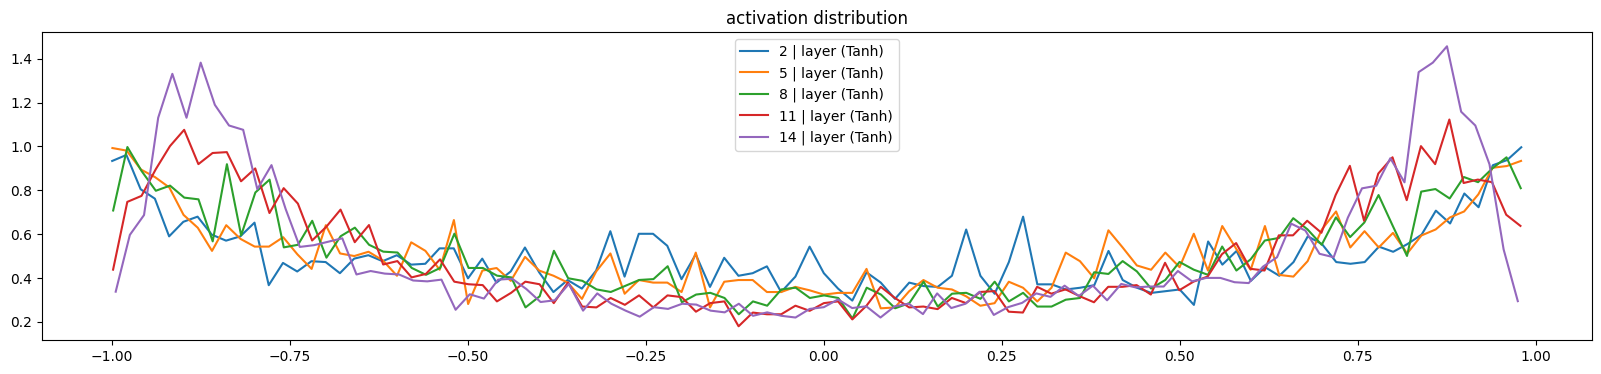

In [176]:
with torch.no_grad():
    plt.figure(figsize=(20,4))
    legends = []
    for i, layer in enumerate(layers):
        if isinstance (layer, Tanh):
            hy, hx = torch.histogram(layer.out, density=True)
            plt.plot(hx[:-1],hy)
            print ('layer %2d | (%10s) | %+.4f mean | %.4f std | saturatted: %.4f%% | shape' % (i, layer.__class__.__name__, layer.out.mean(), layer.out.std(), (layer.out.abs()>0.97).float().mean()*100), tuple(layer.out.shape))
            legends.append(f'{i} | layer ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('activation distribution');

layer  2 | (      Tanh) | -0.0000 mean | 8.7742e-04 std
layer  5 | (      Tanh) | -0.0000 mean | 8.7758e-04 std
layer  8 | (      Tanh) | -0.0000 mean | 8.2833e-04 std
layer 11 | (      Tanh) | +0.0000 mean | 7.7686e-04 std
layer 14 | (      Tanh) | -0.0000 mean | 8.2131e-04 std


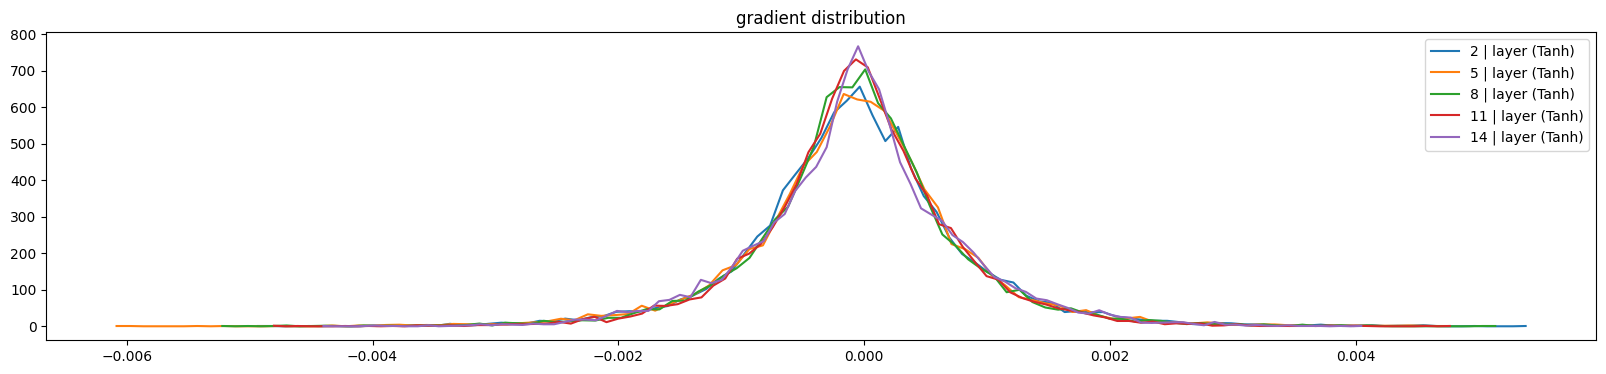

In [177]:
with torch.no_grad():
    plt.figure(figsize=(20,4))
    legends = []
    for i, layer in enumerate(layers):
        if isinstance (layer, Tanh):
            hy, hx = torch.histogram(layer.out.grad, density=True)
            plt.plot(hx[:-1],hy)
            print ('layer %2d | (%10s) | %+.4f mean | %.4e std' % (i, layer.__class__.__name__, layer.out.grad.mean(), layer.out.grad.std()))
            legends.append(f'{i} | layer ({layer.__class__.__name__})')
    plt.legend(legends)
    plt.title('gradient distribution');

params  0 |   (27, 16) | -0.0000 mean | 5.8715e-03 std | ratio grad_std/data_std: 5.9757e-03
params  1 |  (48, 200) | +0.0000 mean | 7.1310e-03 std | ratio grad_std/data_std: 6.4507e-02
params  4 | (200, 200) | +0.0000 mean | 4.0787e-03 std | ratio grad_std/data_std: 7.1178e-02
params  7 | (200, 200) | -0.0000 mean | 3.9686e-03 std | ratio grad_std/data_std: 7.2074e-02
params 10 | (200, 200) | -0.0000 mean | 3.4742e-03 std | ratio grad_std/data_std: 6.5439e-02
params 13 | (200, 200) | +0.0000 mean | 3.0418e-03 std | ratio grad_std/data_std: 5.9630e-02
params 16 |  (200, 27) | -0.0000 mean | 8.6164e-03 std | ratio grad_std/data_std: 9.3935e-02


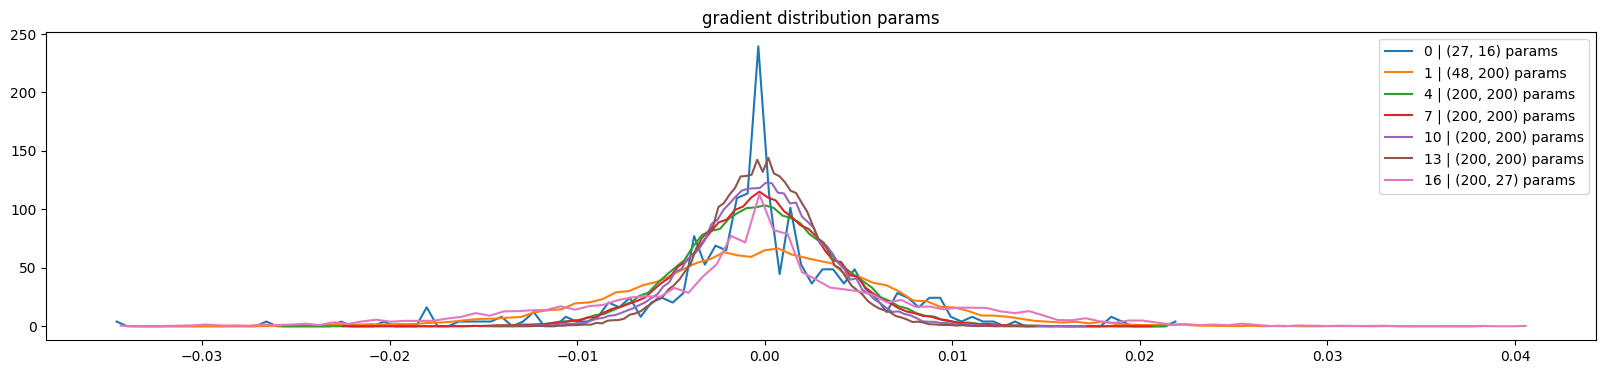

In [179]:
with torch.no_grad():
    plt.figure(figsize=(20,4))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2:
            hy, hx = torch.histogram(p.grad, density=True)
            plt.plot(hx[:-1],hy)
            print ('params %2d | %10s | %+.4f mean | %.4e std | ratio grad_std/data_std: %.4e' % (i, tuple(p.shape), p.grad.mean(), p.grad.std(), p.grad.std()/p.data.std()))
            legends.append(f'{i} | {tuple(p.shape)} params')
    plt.legend(legends)
    plt.title('gradient distribution params');

 0 |   (27, 16) | -0.000 mean | 5.871468e-03 std | ratio update/data: 1.792711e-04
 1 |  (48, 200) | +0.000 mean | 7.131042e-03 std | ratio update/data: 1.935216e-03
 2 |     (200,) | +0.000 mean | 2.021404e-03 std | ratio update/data: 1.728864e-03
 3 |     (200,) | +0.000 mean | 2.272789e-03 std | ratio update/data: 1.684656e-03
 4 | (200, 200) | +0.000 mean | 4.078691e-03 std | ratio update/data: 2.135328e-03
 5 |     (200,) | +0.000 mean | 2.188527e-03 std | ratio update/data: 2.130881e-03
 6 |     (200,) | -0.000 mean | 2.306816e-03 std | ratio update/data: 1.812528e-03
 7 | (200, 200) | -0.000 mean | 3.968573e-03 std | ratio update/data: 2.162233e-03
 8 |     (200,) | +0.000 mean | 1.822890e-03 std | ratio update/data: 1.740875e-03
 9 |     (200,) | -0.000 mean | 2.300534e-03 std | ratio update/data: 1.751780e-03
10 | (200, 200) | -0.000 mean | 3.474216e-03 std | ratio update/data: 1.963185e-03
11 |     (200,) | -0.000 mean | 1.670268e-03 std | ratio update/data: 1.621853e-03
12 |

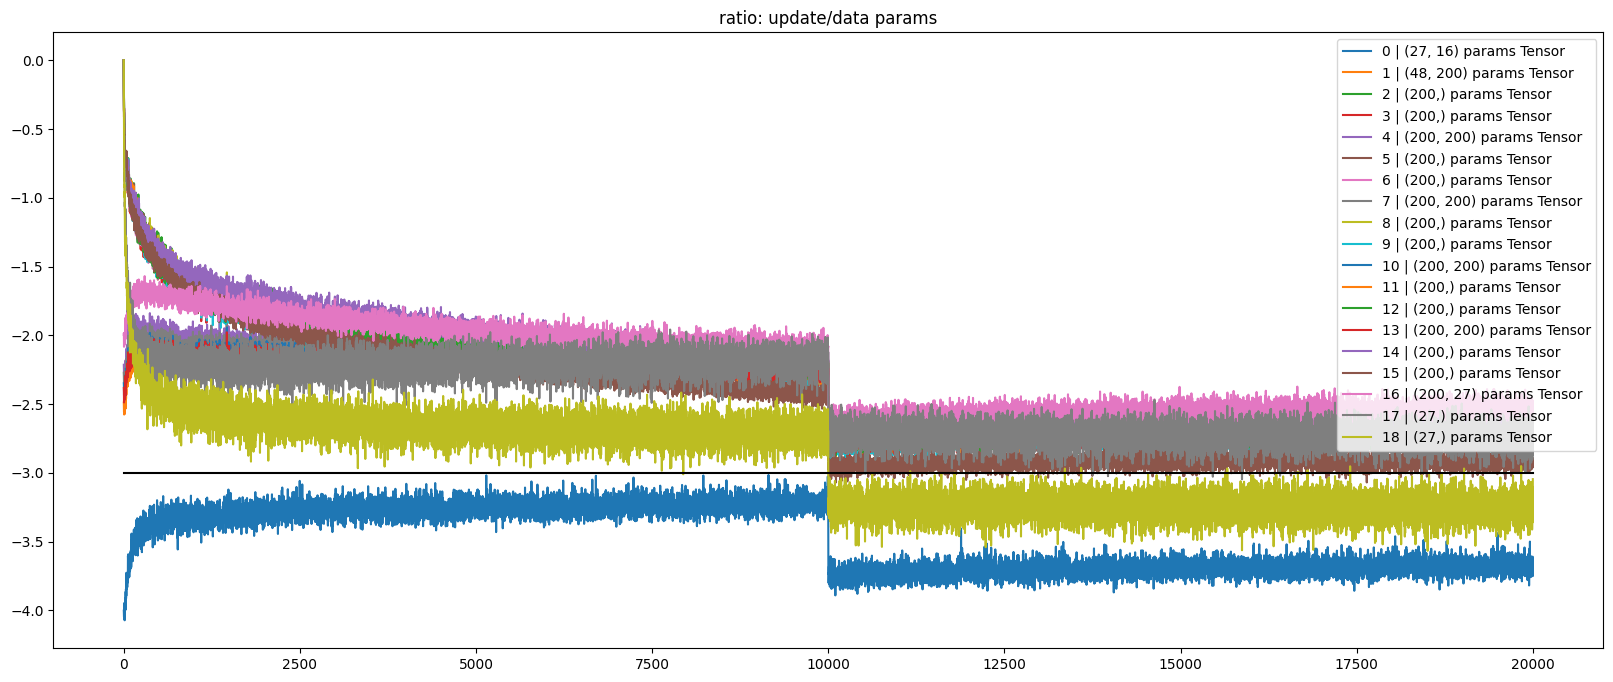

In [180]:
with torch.no_grad():
    plt.figure(figsize=(20,8))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2 or 1:
            plt.plot([utod[j][i] for j in range(len(utod))])
            print ('%2d | %10s | %+.3f mean | %e std | ratio update/data: %e' % (i, tuple(p.shape), p.grad.mean(), p.grad.std(), lr*p.grad.std()/p.data.std()))
            legends.append(f'{i} | {tuple(p.shape)} params {p.__class__.__name__}')
    plt.plot([0, len(utod)], [-3,-3], 'k')
    plt.legend(legends)
    plt.title('ratio: update/data params');

torch.Size([64, 200]) torch.Size([12800])


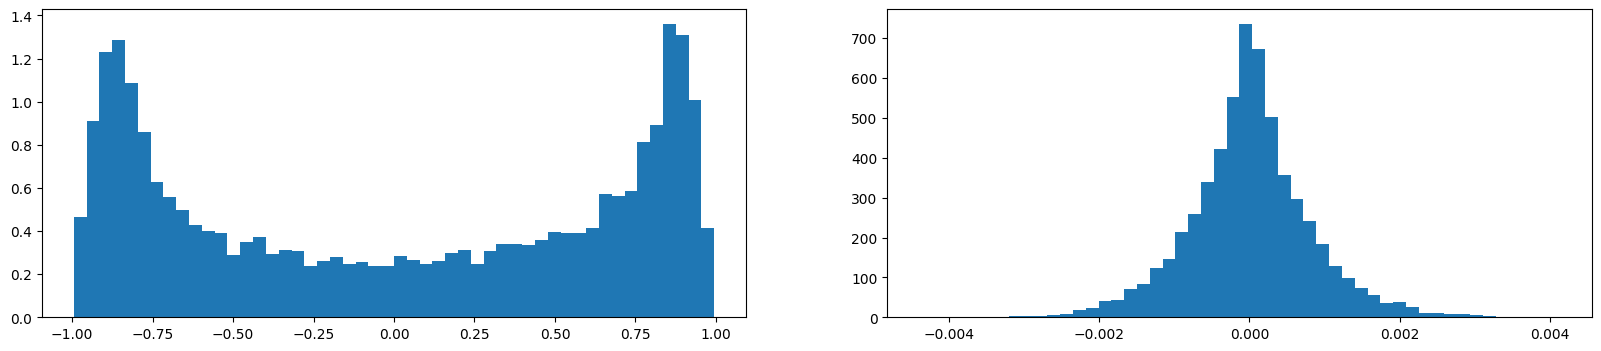

In [181]:
with torch.no_grad():
    for layer in layers[-3:]:
        if isinstance(layer, Tanh):
            print (layer.out.shape, layer.out.view(-1).shape)
            plt.figure(figsize = (20,4))
            plt.subplot(1,2,1)
            plt.hist(layer.out.view(-1).tolist(), 50 ,density=True)
            plt.subplot(1,2,2)
            plt.hist(layer.out.grad.view(-1).tolist(), 50 ,density=True)

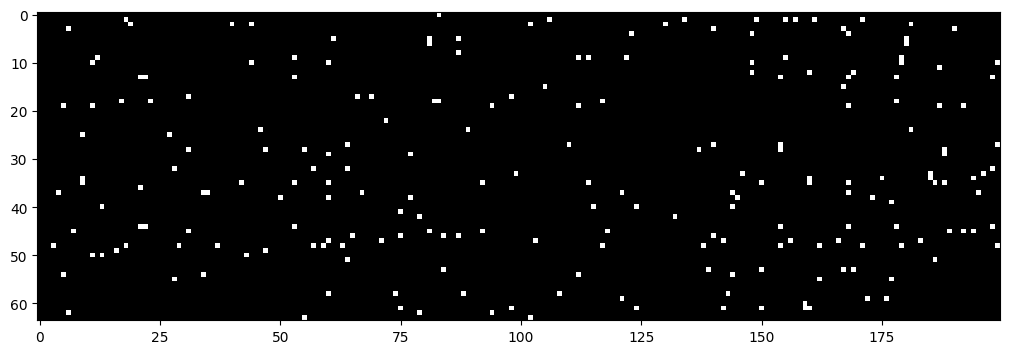

In [182]:
with torch.no_grad():
    plt.figure(figsize = (20,4))
    for layer in layers[-3:]:
        if isinstance(layer, Tanh):
            plt.imshow(layer.out.abs()>0.97, cmap = 'gray', interpolation = 'nearest')

In [185]:
@torch.no_grad()
def evaluate(any_str, fold = False):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[any_str]
    x = (C[x]).view(x.shape[0], -1)
    ##################### E02: #####################
    if fold:
        if len(stop) == 0:
            for layer in reversed(layers):
                if isinstance(layer, Batchnorm1d):
                    layer.training = False
                    gamma = layer.gamma
                    beta = layer.beta
                    var = layer.running_var
                    mean = layer.running_mean
                    eps = layer.eps
                if isinstance(layer, Linear):
                    layer.w = gamma*layer.w/(var+eps).sqrt()
                    layer.b = -gamma*mean/(var+eps).sqrt() + beta
            stop.append('You found an easter egg')
        for layer in layers:
            if isinstance(layer, (Linear,Tanh)):
                x = layer(x)
    ##################### E02: #####################
    else:
        for layer in layers:
            if isinstance(layer, Batchnorm1d):
                layer.training = False
            x = layer(x)
    loss = F.cross_entropy (x, y)
    print(any_str, loss)
evaluate('train', fold = False)
evaluate('val', fold = False)
# train tensor(2.7024)
# val tensor(2.7001)

train tensor(2.0581)
val tensor(2.1088)


In [186]:
evaluate('test', fold = False)

test tensor(2.1057)
